# Advanced Statistical Methods for Data Intensive Science (Lent Term Project)

### Overview

In 1901 Captain Dimitrios Kontos and a crew of sponge divers, retrived numerous large objects from an ancient Roman cargo ship, 45 meters below the sea level, near the island of Antikythera (Greek island located in the Mediterranean Sea). Among the many objects retrived from the wreckage there was a tool, that is now know as the Antikythera mechanism.

The mechanism was designed by ancient Greek astronomers during the second century BC. This was the first known analog computer in human history. This consists of a ca;emdar ring with holes punched at the extrimity of its circumference. Unfortunaly approximatelly $25\%$ of the ring survived. We used to believe that the full ring contained $365$ holes, impling that the mechanism was used as a solar calendar. While, a new theory suggest that there were $354$ holes overall, i.e. the mechanism was a lunar calendar.

### Project Objective

In this project we aim to use an X-ray image of the calendar ring to then infer on the number of holes present in the comple ring, through Bayesian inference with Hamiltonian Monte Carlo. 


In [8]:
# Importing required packages
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import jax.numpy as jnp
from jax import grad, jit, vmap
import iminuit 

### Visualising Data

In [2]:
# Importing data on Antikythera Mechanism (AM) as data_AM
data_AM = pd.read_csv("data/1-Fragment_C_Hole_Measurements.csv")

# Printing data
data_AM  

,Section ID,Hole,Inter-hole Distance,Mean(X),Mean(Y)
0,0,1,NaN,15.59931,92.59653
1,1,2,NaN,16.44167,91.50069
2,1,3,1.440694,17.30764,90.34931
3,1,4,1.456973,18.15278,89.16250
4,1,5,1.299821,18.96528,88.14792
...,...,...,...,...,...
76,7,77,1.259985,108.69444,63.42778
77,7,78,1.430105,110.05486,63.86875
78,7,79,1.179606,111.14583,64.31736
79,7,80,1.428043,112.48021,64.82604


As part of the first task, we want to make a plot of the measured holes $d_i \in \mathbb{R}^2$ in the $x$-$y$ plane, where $i$ labels the holes, to indicate which holes are in each fractured section of the ring. 

In [3]:
# Separating each hole based on their IDs

# Checking what is the maximum value of the Section ID 
print('Maximum value in Section ID:',max(data_AM['Section ID']))

# Max = 7, i.e. 8 sections


Maximum value in Section ID: 7


As we can see the are eight different sections of the Antikythera, let us separate each hole based on each respective section.

/tmp/ipykernel_1196/2969879878.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(data_AM["Section ID"].unique()))


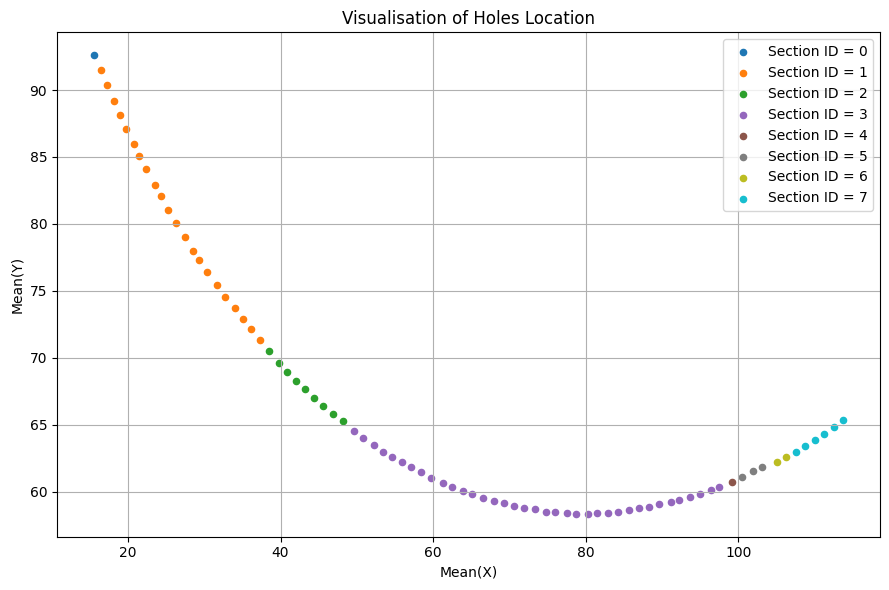

In [24]:
# Define colors using a colormap
colors = plt.cm.get_cmap("tab10", len(data_AM["Section ID"].unique()))

# Plot
plt.figure(figsize=(9, 6))

# Loop through each section and plot automatically
# Selecting different region based on Section ID
for i, (section, data) in enumerate(data_AM.groupby("Section ID")):
    plt.scatter(data["Mean(X)"], data["Mean(Y)"], s=20, color=colors(i), label=f"Section ID = {section}")

# Add labels and title
plt.xlabel('Mean(X)')
plt.ylabel('Mean(Y)')
plt.title('Visualisation of Holes Location')

# Invert y-axis for better visualization (resemble ring shape)
#plt.gca().invert_yaxis()

# Add legend, adjust layout and grid
plt.legend()
plt.tight_layout()
plt.grid()

# Show plot
plt.show()

From section 2 of Ref [[2](https://github.com/MatteoMancini01/S2_Cw/blob/main/relevant_material/2403.00040v1.pdf)] we can breakdown the model for parts (b) and (c) of the project!

### Part (b)

The aim of this section is to code up a model for the hole locations, when considering the following assumptions:

- The original calendar ring had $N$ holes, arranged in regular pattern around a circle of radius $r$.
- Since the remaining the ring fragments are misaligned, the broken sections are allowed to be translated and rotated around the $x$-$y$ plane.
- All the parts of the ring remain within this plane.

Thus, the parameters of the model include:
- The ring radius $r$.
- The total number of holes in the orignial ring $N$.
- A set of transformation parameters (translations and rotations) for each section of the fractured ring.


<b>Theoretical Hole Location</b>

- The expected angular position of each hole $i$ in section $j$:
   $$
   \phi_{ij} = 2\pi \frac{(i-1)}{N} + \alpha_j
   $$
   where $\alpha_j$ is tha angular position of the first hole in the full circle.

- The corresponding Cartesian coordinates are:
   $$
   x_{ij} = r\cos{(\phi_{ij})} + x_{0j}
   $$
   $$
   y_{ij} = r\sin{(\phi_{ij})} + y_{0j}
   $$

- Adjust for section misaligment using the parameters ($x_{0j}, y_{0j}, \alpha_j$) 

In [ ]:
# Model mi, model prediction a dunction of theta
# Use decorator jit to speed up calcualtaion using jax
@jit
def compute_model_hole_positions(N, r, section_params, hole_ids, section_ids):
    """
    Compute modeled hole positions using JAX (this is useful for automatic differentiation, and compatible with numpyro).

    Parameters:
    - N: Total number of holes in the full ring
    - r: Radius of the full ring
    - section_params: Dictionary of (x_j, y_j, alpha_j) per section
    - hole_ids: Array of hole indices
    - section_ids: Array mapping each hole to a section

    Returns:
    - model_x: Modeled x positions
    - model_y: Modeled y positions
    """

    def model_hole(i):
        # Identify section
        section_id = section_ids[i]
        x_j, y_j, alpha_j = section_params.get(section_id, (0.0, 0.0, 0.0))

        # Compute expected hole angle
        phi_i = (2*jnp.pi*(hole_ids[i] - 1))/N + alpha_j

        # Compute modeled coordinates
        x_i = r*jnp.cos(phi_i) + x_j
        y_i = r*jnp.sin(phi_i) + y_j

        return x_i, y_i

    # Vectorize function across all holes
    model_x, model_y = vmap(model_hole)(jnp.arange(len(hole_ids)))

    return model_x, model_y


### Part (c)

The aim of this section is to code up the likelihood function for our model. In particular we are going to implement the following Gaussian likelihood function for the hole locations under the assumption that the errors in the placement of different holes are independent. The likelihood is given by:

$$
\mathcal{L}(D|\vec{\theta}) = \frac{exp(-\frac{1}{2}[\vec{d}_i - \vec{m}_i]^{\text{T}}\cdot \Sigma^{-1}\cdot [\vec{d}_i - \vec{m}_i])}{2\phi |\Sigma|}
$$

Where:
- $D$ is the data set of measured hole locations.
- $\vec{\theta}$ is the set of model parameters.
- $\vec{d}_i$ represents the measured location of the hole $i$.
- $\vec{m}_i$ represents the model-prediction location of the hole $i$.
- $\Sigma$ is the coveriance matrix, which describes the uncartainty in the hole placement.

Furtheremore, we are asked to code up two different models for the coveriance matrix $\Sigma$:
1. <b>Isotropic Gaussian model</b>, the same standard deviation "$\sigma$" applies in all directions.
2. <b>Radial-tangential model</b>, this model uses two different errors, radial $\sigma_r$ and tangential $\sigma_t$.


### Parts (b) and (c)

Breakdown of models used section 2 Ref [[2](https://github.com/MatteoMancini01/S2_Cw/blob/main/relevant_material/2403.00040v1.pdf)].

Model assumptions:

- Originally there were $N$ holes, displayed on a circle of radius $r$
- From data: $\vec{d}_i = (x_i, y_i)$, $1 \leq i \leq n$ in Cartesian coordinates
- Where $n=81$, is the nuber of holes on the arc
- Unknown cercle-centres for each arc: $\vec{r}_{0j} = (x_{0j}, y_{0j})$, for $j \in [0, s-1]$ where $s$ is the number of sections.
- $j^{\text{th}}$ section, $\alpha_j$ is the angular position of the first hole of the full circle.
- $\phi_{ij}$ is the apparent position for the $i^{\text{th}}$ hole in the $j^{\text{th}}$ section:
  $$
  \phi_{ij} = 2\pi \frac{(i-1)}{N} + \alpha_j
  $$
- Three unknown paramters ($x_{0j}, y_{0j}, \alpha_j$), defining displacement and roatation.
- No internal distribution per sections and all lie in the ($x,y$) plane.
- Using Bayesian analysis, let $\vec{a} = (N,r,\{(x_{0j}, y_{0j})\}, \{\alpha_{j}\}, C)$, hence the PDF for $N$, given the dataset {$d_j$}, can be computed by marginalising over the other parameters in $\vec{a}$.
- Initially consider $N$ as a continuous parameter.
- Use Gaussian PDF for the errors in measurament and placement of the holes:
  $$
  \vec{e}_{ij} = \vec{r}_{ij} - (\vec{d}_i - \vec{r}_{0j}) 
  $$
  where:
    - $\vec{r}_{ij}$ is the predicted position
    - $\vec{d}_i$ is the data point
    - $\vec{r}_{0j}$ is the shifted origin
-  

### Model 

In [19]:
def model(x, y, R, phis, xcent, ycent, phase):

    ''' 
    Compute the radial and tangential errors between measured hole position and predicted hole locations
    in the fractured ring model.

    This function models the expected hole positions assuming an originally circular ring with N regularly spaced holes. 
    It then accounts for misaligment by applying transformation (xcent, ycent), in paper refered as $(x_{0j}, y_{0j})$, and a phase
    shift. Finally, it computes the errors between the measuered and predicted hole positions, projecting them into radial and 
    tangential components.

    Parameters:

    x : np.array
        Measured x-coordinates of hole positions for a specific fractured section. 
    y : np.array
        Measured y-coordinates of hole positions for a secific fracured section. 
    R : float
        Estimated radius of the original ring
    phis : np.array
        Angles of the holes in the unbroken ring, evenly spaced between 0 and 2pi
    xcent : float
        x-coordinate of the estimated center if the fractured section
    ycent : float
        y-coordinate of the estimated center of the fractured section
    phase : float
        Phase shift applied to align the hole positions.

    Returns:
    
    rp : np.array
        Radial errors (distance from the expected radius). 
    tp : np.array 
        Tangential errors (misaligment along the circumference of the ring). 

    '''

    phi = phis + phase # Apply phase shift to the angles

    cphi = np.cos(phi) # Compute cosine values
    sphi = np.sin(phi) # Compute sine values

    # compute model points in x,y
    r_x = R*cphi # X-coordinates of prediceted holes
    r_y = R*sphi # Y-coordinates of predicted holes

    # shift data point to be around model x,y
    d_x = x - xcent 
    d_y = y - ycent

    # find error vector between data and model
    e_x = r_x - d_x
    e_y = r_y - d_y

    # project vector into radius and tangent
    rp = e_x*cphi + e_y*sphi # Radial projection
    tp = e_x*sphi - e_y*cphi # Tangential projection

    return rp, tp

In [ ]:
# Quick check model

x_measured = np.array([10.5, 11.2, 9.8])
y_measured = np.array([5.3, 4.9, 5.7])
R = 10
phis = np.linspace(0, 2*np.pi, len(x_measured))
xcent, ycent, phase = 0.5, -0.3, 0.1
rp, tp = model(x_measured, y_measured, R, phis, xcent, ycent, phase)

print(rp,tp)

[-0.50910879 21.16567834  0.14746076] [ 4.57368916 -4.1058041   5.04157422]


### Gaussian Log-Likelihood for Radial and Tangential components (code from paper not jaxified!)

In [39]:
def log_likelihood_rt(params, data, N):
    '''
    Compute log-likelihood for the isotropic Gaussian error model.

    Parameters:
    params (list): Model parameters [R, sigma_r, sigma_t, phase1, phase2, ..., xcent1, xcent2, ..., ycent1, ycent2, ...]
    data (list of tuples): Measured hole positions for each fractured section.
    N (int): Total number of holes in the original complete ring.

    Returns:
    float: Log-likelihood value.
    '''

    R, sigma_r, sigma_t = params[:3]
    phases, xcents, ycents = np.split(params[3:], 3)
    #x,y = data

    invsig_r = 1./(2*(sigma_r*sigma_r))
    invsig_t = 1./(2*(sigma_t*sigma_t))

    npoints = np.sum([len(dt) for dt in data])
    prefact = -npoints*np.log(2*np.pi*sigma_t*sigma_r)
    phis = 2*np.pi*np.arange(100)/N

    #k = np.arange(N)
    exp_likelihood = 0
    for i, sect in enumerate(data):
        x,y = sect

        # assume independent r, tangent
        rp, tp = model(x, y, R, phis[:len(x)], xcents[i], ycents[i], phases[i])

        exponent = -invsig_r*(rp**2) - invsig_t*(tp**2)

        exp_likelihood += np.sum(exponent)


    return prefact + exp_likelihood

### Gaussian Log-Likelihood for Isometric Model (code from paper modified and not jaxified)

In [228]:
def log_likelihood_isotropic(params, data, N):
    '''
    Compute log-likelihood for the isotropic Gaussian error model.

    Parameters:
    params (list): Model parameters [R, sigma, phase1, phase2, ..., xcent1, xcent2, ..., ycent1, ycent2, ...]
    data (list of tuples): Measured hole positions for each fractured section.
    N (int): Total number of holes in the original complete ring.

    Returns:
    float: Log-likelihood value.
    '''
    
    # Extract parameters
    R, sigma = params[:2]  # Only one sigma for isotropic model
    phases, xcents, ycents = np.split(params[2:], 3)

    # Compute inverse variance term
    invsig = 1./(2*sigma**2)

    # Compute number of points for normalization term
    npoints = np.sum([len(dt) for dt in data])
    prefact = -npoints*np.log(2*np.pi*sigma**2)

    # Generate equally spaced angles for the full ring
    phis = 2*np.pi*np.arange(100) / N

    # Compute log-likelihood
    exp_likelihood = 0
    for i, sect in enumerate(data):
        x, y = sect  # Measured hole positions in section i

        # Get predicted positions from the model
        m_x, m_y = model(x, y, R, phis[:len(x)], xcents[i], ycents[i], phases[i])

        # Isotropic Gaussian exponent
        exponent = -invsig*(m_x**2 + m_y**2)

        # Accumulate log-likelihood
        exp_likelihood += np.sum(exponent)

    return prefact + exp_likelihood

### Part (e)

Need to define NLL (negative log-likelihood), for both models, before applying iminuit, which is a minimiser, hence by minimising NLL, we are maximising the log-likelihood. But before proceeding we shall remove two of the sections in the data, this was also done in the paper, as sections 0 and 4 only have one data point, i.e. they do not have a big impact on the model, hence our new dataset will have 6 sections and 79 holes, this means, one can code up a negative log likelihood just for those 6 sections. 


(NEED TO IMPROVE WRITING IN THIS MD CELL!)

### Step 1: Clean the data

Here our goal is to remove section 0 and 4, one can do this usnig the pakage `pandas`. We are going to name the new dataset `sub_data`

In [36]:
sub_data = data_AM[~data_AM['Section ID'].isin([0,4])] # removing sections 0 and 4
sub_data.shape # Quick check

(79, 5)

<b>Plotting `sub_data`</b>

Using the same code as before, but substitute `data_AM` with `sub_data`.

/tmp/ipykernel_1196/19440131.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(sub_data["Section ID"].unique()))


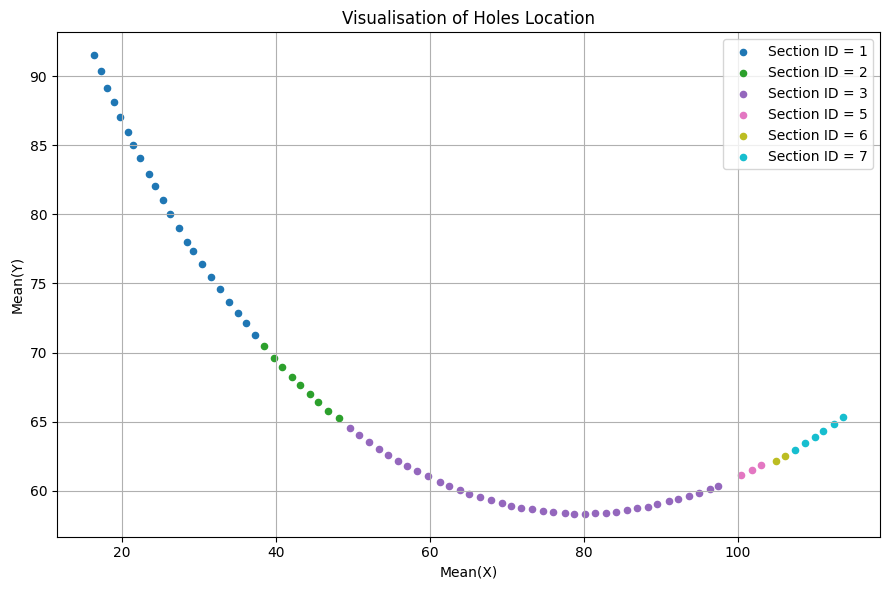

In [143]:
# Define colors using a colormap
colors = plt.cm.get_cmap("tab10", len(sub_data["Section ID"].unique()))

# Plot
plt.figure(figsize=(9, 6))

# Loop through each section and plot automatically
# Selecting different region based on Section ID
for i, (section, data) in enumerate(sub_data.groupby("Section ID")):
    plt.scatter(data["Mean(X)"], data["Mean(Y)"], s=20, color=colors(i), label=f"Section ID = {section}")

# Add labels and title
plt.xlabel('Mean(X)')
plt.ylabel('Mean(Y)')
plt.title('Visualisation of Holes Location')

# Invert y-axis for better visualization (resemble ring shape)
#plt.gca().invert_yaxis()

# Add legend, adjust layout and grid
plt.legend()
plt.tight_layout()
plt.grid()

# Show plot
plt.show()

### Step 2: Define a NLL for each model (isotropic and central)

### Isostropic Model

In [224]:
import numpy as np
from iminuit import Minuit

def neg_log_likelihood_is(N, R, sigma,
                       phase_0, phase_1, phase_2, phase_3, phase_4, phase_5,
                       xcent_0, xcent_1, xcent_2, xcent_3, xcent_4, xcent_5,
                       ycent_0, ycent_1, ycent_2, ycent_3, ycent_4, ycent_5):
    """
    Compute the negative log-likelihood for 6 sections dynamically.

    Parameters:
    N, R, sigma_r, sigma_t : float
        Model parameters for ring radius and error standard deviations.
    phase_i, xcent_i, ycent_i : float
        Phase shifts and translations for each of the 6 sections.

    Returns:
    float
        Negative log-likelihood value (to be minimized by iminuit).
    """
    # Convert parameters into arrays to avoid shape issues
    phases = np.array([phase_0, phase_1, phase_2, phase_3, phase_4, phase_5])
    xcents = np.array([xcent_0, xcent_1, xcent_2, xcent_3, xcent_4, xcent_5])
    ycents = np.array([ycent_0, ycent_1, ycent_2, ycent_3, ycent_4, ycent_5])

    # Ensure data is a NumPy array before passing it
    global data
    data = np.array(data, dtype=object)  # Convert data list to a NumPy array (dtype=object keeps tuples)

    # Compute log-likelihood and negate it
    params = np.array([R, sigma, *phases, *xcents, *ycents])  # Convert to array to avoid issues
    return -log_likelihood_isotropic(params, data, N)  # Negate log-likelihood for minimization

# Example setup for 6 sections

num_sections = 6  # Now using 6 sections


data = [(sub_data['Mean(X)'], sub_data['Mean(Y)'])]


# Initial parameter estimates for 6 sections
N = 355
R_init = 77.0
sigma_init = 0.1
phases_init = [-2.53, -2.53, -2.53, -2.54, -2.55, -2.55]
xcents_init = [79, 79, 79, 81, 81, 83]
ycents_init = [136, 135, 135, 136, 135, 136]

# Combine parameters into one list
init_params = [N, R_init, sigma_init, *phases_init, *xcents_init, *ycents_init]

m_is = Minuit(neg_log_likelihood_is, 
           N=init_params[0], R=init_params[1], sigma=init_params[2],
           phase_0=init_params[3], phase_1=init_params[4], phase_2=init_params[5], 
           phase_3=init_params[6], phase_4=init_params[7], phase_5=init_params[8],
           xcent_0=init_params[9], xcent_1=init_params[10], xcent_2=init_params[11], 
           xcent_3=init_params[12], xcent_4=init_params[13], xcent_5=init_params[14],
           ycent_0=init_params[15], ycent_1=init_params[16], ycent_2=init_params[17], 
           ycent_3=init_params[18], ycent_4=init_params[19], ycent_5=init_params[20])

# Define likelihood optimization settings
m_is.errordef = Minuit.LIKELIHOOD
m_is.limits['N'] = (345, 365)  # Set realistic bounds for N
m_is.limits['R'] = (60, 80)
m_is.limits['sigma'] = (0, None)  # sigma must be positive


# Run the minimization
m_is.migrad()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8.515                      │             Nfcn = 1210              │
│ EDM = 4.97e-05 (Goal: 0.0001)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N       │   351.0   │    1.8    │            │            │   345   │   365   │       │
│ 1 │ R       │   77.79   │   0.28    │            │            │   60    │   80    │       │
│ 2 │ sigma   │    2.0    │    0.7    │            │            │    0    │         │       │
│ 3 │ phase_0 │  -2.533   │   0.007   │            │            │         │         │       │
│ 4 │ phase_1 │   -2.5    │    1.0    │            │            │         │         │       │
│ 5 │ phase_2 │   -2.5    │    1.0    │            │            │         │         │       │
│ 6 │ phase_3 │   -2.5    │    1.0    │            │            │         │         │       │
│ 7 │ phase_4 │   -2.6    │    1.0    │            │            │         │         │       │
│ 8 │ phase_5 │   -2.6    │    1.0    │            │            │         │         │       │
│ 9 │ xcent_0 │   80.2    │    0.6    │            │            │         │         │       │
│ 10│ xcent_1 │    79     │     1     │            │            │         │         │       │
│ 11│ xcent_2 │    79     │     1     │            │            │         │         │       │
│ 12│ xcent_3 │    81     │     1     │            │            │         │         │       │
│ 13│ xcent_4 │    81     │     1     │            │            │         │         │       │
│ 14│ xcent_5 │    83     │     1     │            │            │         │         │       │
│ 15│ ycent_0 │  136.11   │   0.24    │            │            │         │         │       │
│ 16│ ycent_1 │    135    │     1     │            │            │         │         │       │
│ 17│ ycent_2 │    135    │     1     │            │            │         │         │       │
│ 18│ ycent_3 │    136    │     1     │            │            │         │         │       │
│ 19│ ycent_4 │    135    │     1     │            │            │         │         │       │
│ 20│ ycent_5 │    136    │     1     │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│         │        N        R    sigma  phase_0  phase_1  phase_2  phase_3  phase_4  phase_5  xcent_0  xcent_1  xcent_2  xcent_3  xcent_4  xcent_5  ycent_0  ycent_1  ycent_2  ycent_3  ycent_4  ycent_5 │
├─────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│       N │     3.24    -0.30      0.1  2.35e-3      0.0      0.0      0.0      0.0      0.0      0.2      0.0      0.0      0.0 

Collecting optimised parameters

In [234]:
N_opt_is = m_is.values["N"]  # Optimised number of holes
R_opt_is = m_is.values["R"]  # Optimised ring radius
sigma_opt_is = m_is.values["sigma"]  # Error

# Extract section-wise parameters into arrays
num_sections = 6  # Assuming 6 sections

phases_opt_is = np.array([m_is.values[f"phase_{i}"] for i in range(num_sections)])
xcents_opt_is = np.array([m_is.values[f"xcent_{i}"] for i in range(num_sections)])
ycents_opt_is = np.array([m_is.values[f"ycent_{i}"] for i in range(num_sections)])

# Store all extracted parameters in a structured array
optimised_params_is = np.array([phases_opt_is, xcents_opt_is, ycents_opt_is])

# Print results for verification
print("Optimised Parameters Array (phases, xcenters, ycenters):")
print("")
print(optimised_params_is)

Optimised Parameters Array (phases, xcenters, ycenters):

[[ -2.53292162  -2.53        -2.53        -2.54        -2.55
   -2.55      ]
 [ 80.20611246  79.          79.          81.          81.
   83.        ]
 [136.10522381 135.         135.         136.         135.
  136.        ]]


### Radial-Tangential model

In [144]:
import numpy as np
from iminuit import Minuit

def neg_log_likelihood_rt(N, R, sigma_r, sigma_t,
                       phase_0, phase_1, phase_2, phase_3, phase_4, phase_5,
                       xcent_0, xcent_1, xcent_2, xcent_3, xcent_4, xcent_5,
                       ycent_0, ycent_1, ycent_2, ycent_3, ycent_4, ycent_5):
    """
    Compute the negative log-likelihood for 6 sections dynamically.

    Parameters:

    N, R, sigma_r, sigma_t : float
        Model parameters for ring radius and error standard deviations.
    phase_i, xcent_i, ycent_i : float
        Phase shifts and translations for each of the 6 sections.

    Returns:
    float
        Negative log-likelihood value (to be minimized by iminuit).
    """
    # Convert parameters into arrays to avoid shape issues
    phases = np.array([phase_0, phase_1, phase_2, phase_3, phase_4, phase_5])
    xcents = np.array([xcent_0, xcent_1, xcent_2, xcent_3, xcent_4, xcent_5])
    ycents = np.array([ycent_0, ycent_1, ycent_2, ycent_3, ycent_4, ycent_5])

    # Ensure data is a NumPy array before passing it
    global data
    data = np.array(data, dtype=object)  # Convert data list to a NumPy array (dtype=object keeps tuples)

    # Compute log-likelihood and negate it
    params = np.array([R, sigma_r, sigma_t, *phases, *xcents, *ycents])  # Convert to array to avoid issues
    return -log_likelihood_rt(params, data, N)  # Negate log-likelihood for minimization

# Example setup for 6 sections

num_sections = 6  # Now using 6 sections


data = [(sub_data['Mean(X)'], sub_data['Mean(Y)'])]


# Initial parameter estimates for 6 sections
N = 355
R_init = 77
sigma_r_init = 0.03
sigma_t_init = 0.13
phases_init = [-2.53, -2.53, -2.53, -2.54, -2.55, -2.55]
xcents_init = [79, 79, 79, 81, 81, 83]
ycents_init = [136, 135, 135, 136, 135, 136]

# Combine parameters into one list
init_params = [N, R_init, sigma_r_init, sigma_t_init, *phases_init, *xcents_init, *ycents_init]

m_rt = Minuit(neg_log_likelihood_rt, 
           N=init_params[0], R=init_params[1], sigma_r=init_params[2], sigma_t=init_params[3],
           phase_0=init_params[4], phase_1=init_params[5], phase_2=init_params[6], 
           phase_3=init_params[7], phase_4=init_params[8], phase_5=init_params[9],
           xcent_0=init_params[10], xcent_1=init_params[11], xcent_2=init_params[12], 
           xcent_3=init_params[13], xcent_4=init_params[14], xcent_5=init_params[15],
           ycent_0=init_params[16], ycent_1=init_params[17], ycent_2=init_params[18], 
           ycent_3=init_params[19], ycent_4=init_params[20], ycent_5=init_params[21])

# Define likelihood optimization settings
m_rt.errordef = Minuit.LIKELIHOOD
m_rt.limits['N'] = (345, 365)  # Set realistic bounds for N
m_rt.limits['R'] = (60, 80)
m_rt.limits['sigma_r'] = (0, None)  # sigma_r must be positive
m_rt.limits['sigma_t'] = (0, None)  # sigma_t must be positive

# Run the minimization
m_rt.migrad()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 7.497                      │             Nfcn = 1336              │
│ EDM = 3.85e-05 (Goal: 0.0001)    │            time = 0.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N       │    357    │     4     │            │            │   345   │   365   │       │
│ 1 │ R       │   79.15   │   0.18    │            │            │   60    │   80    │       │
│ 2 │ sigma_r │    0.6    │    0.1    │            │            │    0    │         │       │
│ 3 │ sigma_t │    3.1    │    0.4    │            │            │    0    │         │       │
│ 4 │ phase_0 │  -2.521   │   0.009   │            │            │         │         │       │
│ 5 │ phase_1 │   -2.5    │    1.0    │            │            │         │         │       │
│ 6 │ phase_2 │   -2.5    │    1.0    │            │            │         │         │       │
│ 7 │ phase_3 │   -2.5    │    1.0    │            │            │         │         │       │
│ 8 │ phase_4 │   -2.6    │    1.0    │            │            │         │         │       │
│ 9 │ phase_5 │   -2.6    │    1.0    │            │            │         │         │       │
│ 10│ xcent_0 │   80.67   │   0.17    │            │            │         │         │       │
│ 11│ xcent_1 │    79     │     1     │            │            │         │         │       │
│ 12│ xcent_2 │    79     │     1     │            │            │         │         │       │
│ 13│ xcent_3 │    81     │     1     │            │            │         │         │       │
│ 14│ xcent_4 │    81     │     1     │            │            │         │         │       │
│ 15│ xcent_5 │    83     │     1     │            │            │         │         │       │
│ 16│ ycent_0 │  137.50   │   0.26    │            │            │         │         │       │
│ 17│ ycent_1 │    135    │     1     │            │            │         │         │       │
│ 18│ ycent_2 │    135    │     1     │            │            │         │         │       │
│ 19│ ycent_3 │    136    │     1     │            │            │         │         │       │
│ 20│ ycent_4 │    135    │     1     │            │            │         │         │       │
│ 21│ ycent_5 │    136    │     1     │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│         │        N        R  sigma_r  sigma_t  phase_0  phase_1  phase_2  phase_3  phase_4  phase_5  xcent_0  xcent_1  xcent_2  xcent_3  xcent_4  xcent_5  ycent_0  ycent_1  ycent_2  ycent_3  ycent_4  ycent_5 │
├─────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│       

Collecting optimised parameters

In [153]:
N_opt_rt = m_rt.values["N"]  # Optimised number of holes
R_opt_rt = m_rt.values["R"]  # Optimised ring radius
sigma_r_opt_rt = m_rt.values["sigma_r"]  # Radial error
sigma_t_opt_rt = m_rt.values["sigma_t"]  # Tangential error

# Extract section-wise parameters into arrays
num_sections = 6  # Assuming 6 sections

phases_opt_rt = np.array([m_rt.values[f"phase_{i}"] for i in range(num_sections)])
xcents_opt_rt = np.array([m_rt.values[f"xcent_{i}"] for i in range(num_sections)])
ycents_opt_rt = np.array([m_rt.values[f"ycent_{i}"] for i in range(num_sections)])

# Store all extracted parameters in a structured array
optimised_params_rt = np.array([phases_opt_rt, xcents_opt_rt, ycents_opt_rt])

# Print results for verification
print("Optimised Parameters Array (phases, xcenters, ycenters):")
print("")
print(optimised_params_rt)
print(optimised_params_rt[0][0])

Optimised Parameters Array (phases, xcenters, ycenters):

[[ -2.52139582  -2.53        -2.53        -2.54        -2.55
   -2.55      ]
 [ 80.67068264  79.          79.          81.          81.
   83.        ]
 [137.49801229 135.         135.         136.         135.
  136.        ]]
-2.5213958154964344


### Visualising Predicted vs Measured.

Now that we have determined the parameters estimates using the MLE method, we can now code up a function to display models predictions on a plot for each section, and compare the perdicted hole location to the measured location. 

Recall the following assumpiotns: 
- Unknown cercle-centres for each arc: $\vec{r}_{0j} = (x_{0j}, y_{0j})$, for $j \in [0, s-1]$ where $s$ is the number of sections.
- $j^{\text{th}}$ section, $\alpha_j$ is the angular position of the first hole of the full circle.
- $\phi_{ij}$ is the apparent position for the $i^{\text{th}}$ hole in the $j^{\text{th}}$ section:
  $$
  \phi_{ij} = 2\pi \frac{(i-1)}{N} + \alpha_j
  $$
- Three unknown paramters ($x_{0j}, y_{0j}, \alpha_j$), defining displacement and roatation.

Hence the predifcted holes location can be modelled as follow:

$$
x_{ij} = R \cos{\phi_{ij}} + x_{0j}
$$#
$$
y_{ij} = R \sin{\phi_{ij}} + y_{0j}
$$


In [180]:
# Converting Section ID into array format using .to_numpy()
sec_id_sub = sub_data['Section ID'].to_numpy()
print('Section ID before adaptation to new format:')
print(sec_id_sub)

print('')

'''  
For our likelihood models we have labeled sections from 0 to 5, but the observed data is 
registered with section id from 1 to 7, exluding sections 0 and 4. 

The objective is to relabel the Section ID from 0 to 5, by subtracting 1 when elements in Section ID
are less than 4, and subtract 2 otherwise.

'''

sec_mod = np.array([x-1 if x < 4 else x - 2 for x in sec_id_sub]) 
print('Section ID adapted to new format:')
print(sec_mod)

Section ID before adaptation to new format:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 6 6 7
 7 7 7 7 7]

Section ID adapted to new format:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 4 4 5
 5 5 5 5 5]


In [231]:
def hole_prediction(N, R, optim_parm):

    x_pred = [] # x_ij
    y_pred = [] # y_ij
    
    # 79 measured holes
    for i in range(0, 79):

        phi_val = 2*np.pi*(i)/N + optim_parm[0][sec_mod[i]] # Computing phi_ij values

        x_val = R*np.cos(phi_val) + optim_parm[1][sec_mod[i]] # Computing x_ij values
        y_val = R*np.sin(phi_val) + optim_parm[2][sec_mod[i]] # Computing x_ij values

        x_pred.append(x_val)
        y_pred.append(y_val)
    
    return np.array([x_pred, y_pred])


In [ ]:
# Computing hole predicted location using predicted parameters from Iminuit for:

# Radial-Tangential Model:
predicted_hole_loc_rt = hole_prediction(N_opt_rt, R_opt_rt, optimised_params_rt)

# Isotropic Model:
predicted_hole_loc_is = hole_prediction(N_opt_is, R_opt_is, optimised_params_is)
